1st Notebook to perform a 1st high level analysis of the data:

Working on a famous Kaggle Dataset for Motor Claims in France:<br>
https://www.kaggle.com/datasets/floser/french-motor-claims-datasets-fremtpl2freq

Context

In the dataset freMTPL2freq risk features and claim numbers were collected for 677,991 motor third-part liability policies (observed on a year).

## Libraries used

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import Image

## Load data

In [5]:
claims_data = pd.read_csv('../Dataset/FreMTPL2freq.csv')
claims_data.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [6]:
print('size of the data set: ', claims_data.shape)

size of the data set:  (678013, 12)


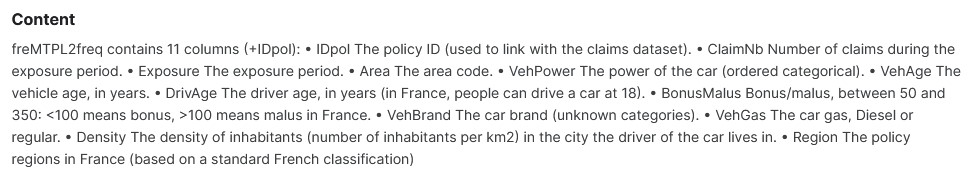

In [7]:
# basic description of the data
Image(filename= '../Dataset/data.jpg')

## Investigate Data

In [8]:
# check if some policy numbers are appearing more than once in the data set
check_idpol = claims_data.groupby('IDpol').agg(count=('IDpol', 'count')).reset_index()
check_idpol.sort_values(by = 'count', ascending = False).head()

,IDpol,count
0,1.0,1
452003,3179319.0,1
452005,3179322.0,1
452006,3179324.0,1
452007,3179325.0,1


Finding: every ID is just appearing once

In [9]:
# check for missing data
claims_data.isna().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

Finding: there are no missing values

In [11]:
claims_data.duplicated().sum()

0

Finding: there are no duplicate records in the dataset

In [53]:
# check data types
print('variables and data types:\n\n', claims_data.dtypes, '\n')
print('Sum of variable types:\n\n',claims_data.dtypes.value_counts())

variables and data types:

 IDpol         float64
ClaimNb         int64
Exposure      float64
Area           object
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Density         int64
Region         object
dtype: object 

Sum of variable types:

 int64      6
object     4
float64    2
Name: count, dtype: int64


Findings:
- ClaimNb is the target variable the should be modelled
- There are some categorical variables that need to be encoded

In [55]:
claims_data.columns

Index(['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region'],
      dtype='object')

In [12]:
check_cols = ['ClaimNb', 'Area', 'VehAge', 'VehPower', 'BonusMalus', 'VehBrand', 'VehGas', 'Region']

In [13]:
claims_data.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


#### bar-plots on value counts

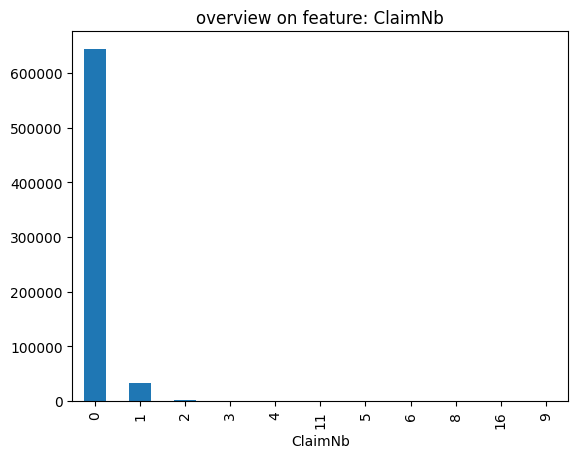

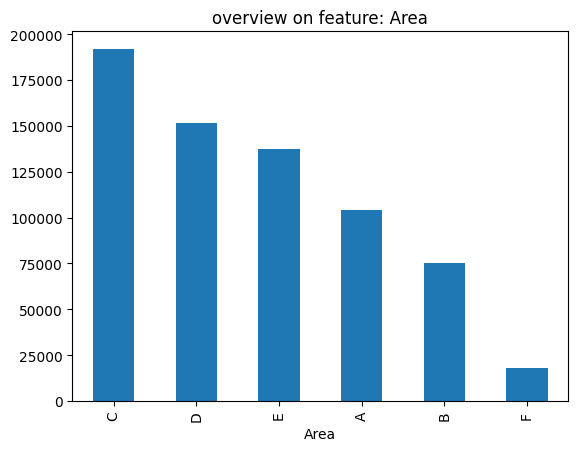

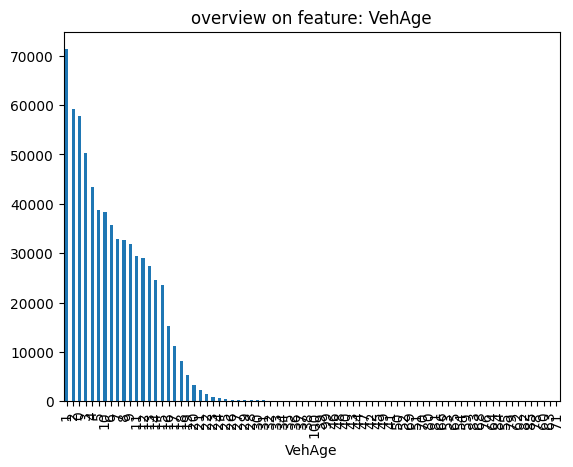

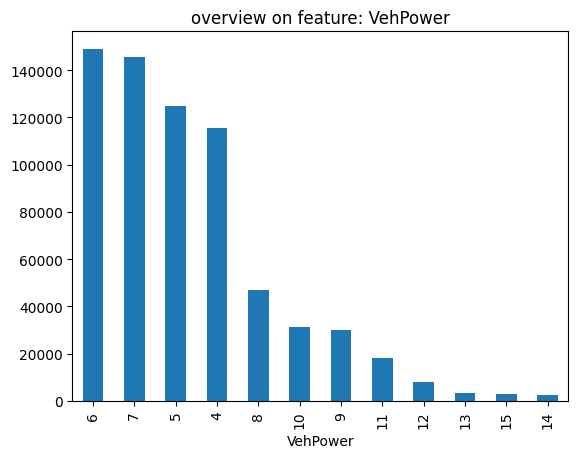

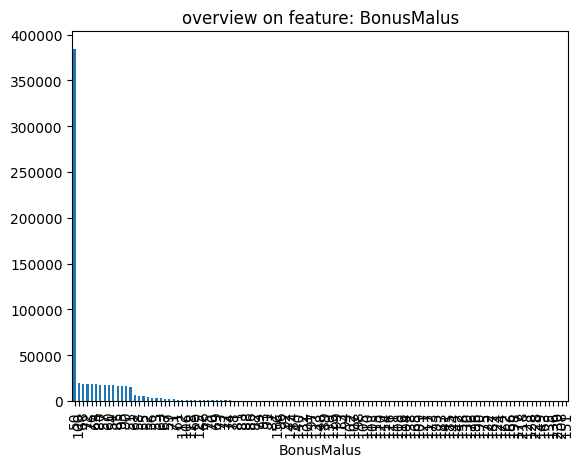

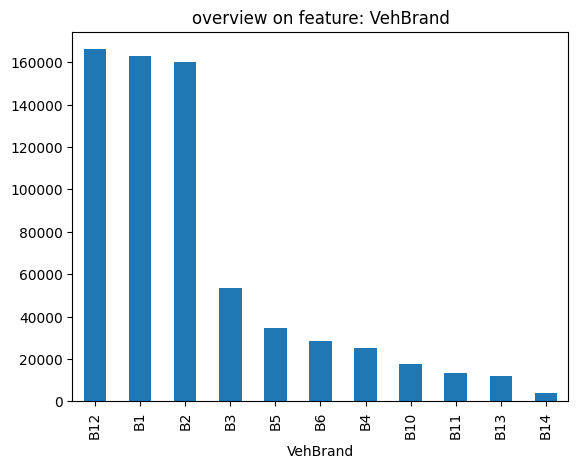

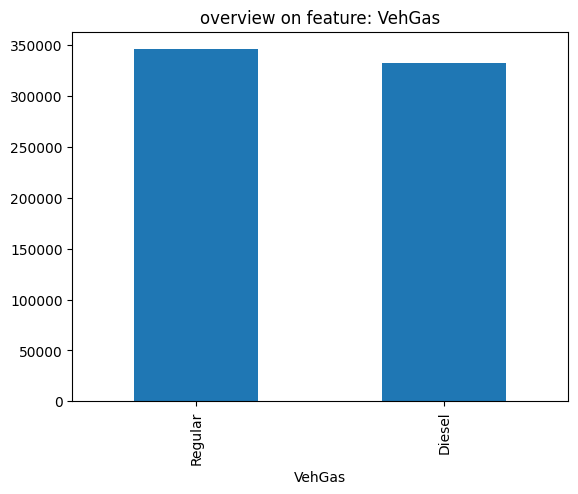

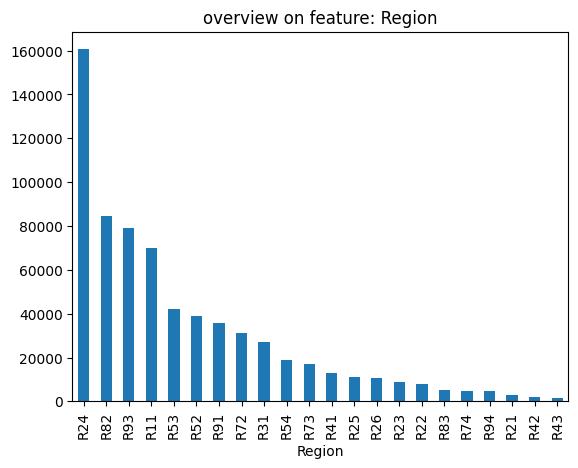

In [14]:
# do some simple value counts for categorical and integer features where low number is expected
for col in check_cols:
    claims_data[col].value_counts().plot(kind='bar')
    plt.title('overview on feature: ' + col)
    plt.show()

In [79]:
claims_data['BonusMalus'].value_counts()

BonusMalus
50     384156
100     19530
68      18791
72      18580
76      18226
        ...  
135         1
136         1
230         1
208         1
151         1
Name: count, Length: 115, dtype: int64

#### hist-plots on value counts

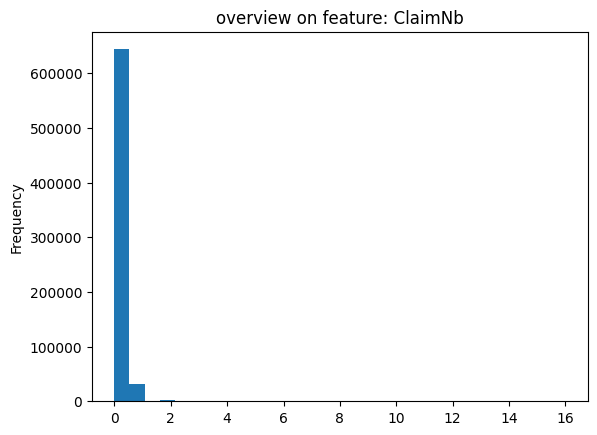

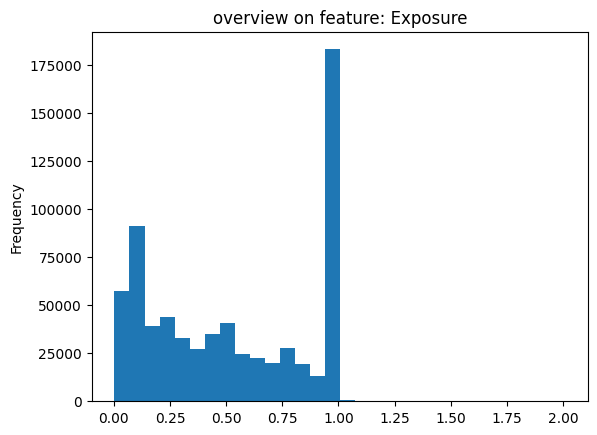

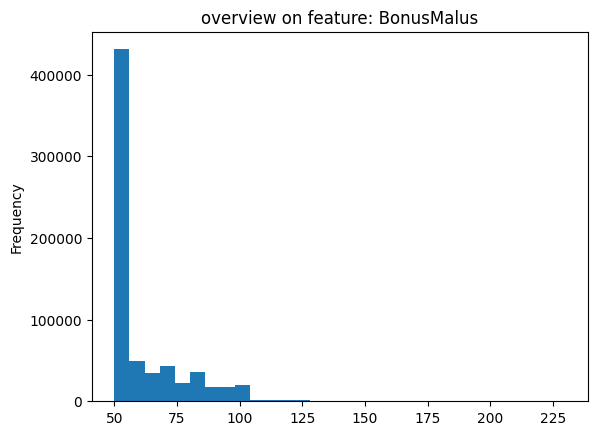

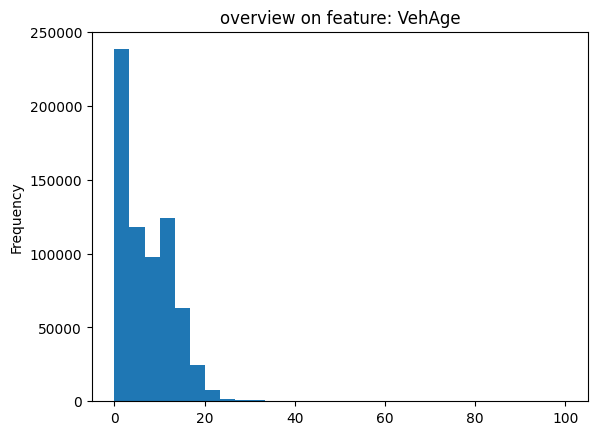

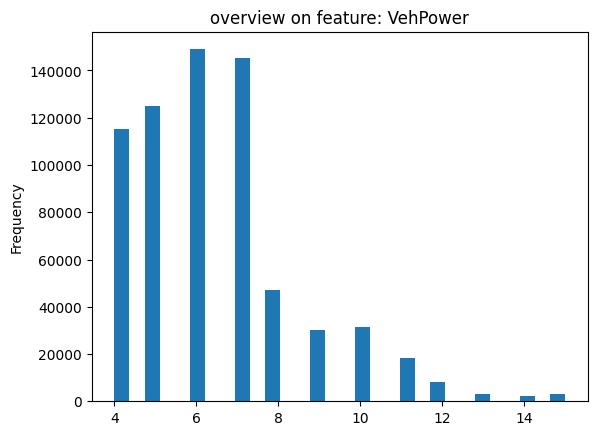

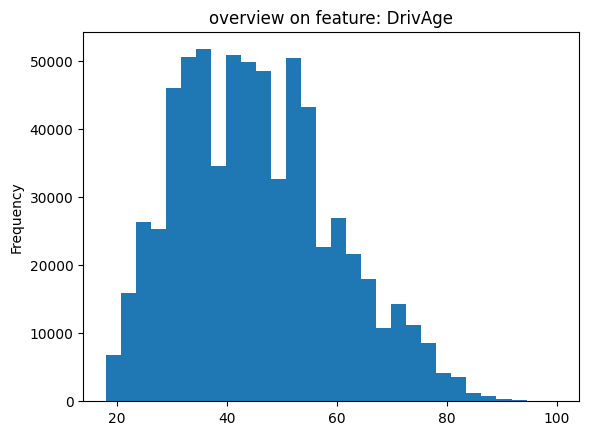

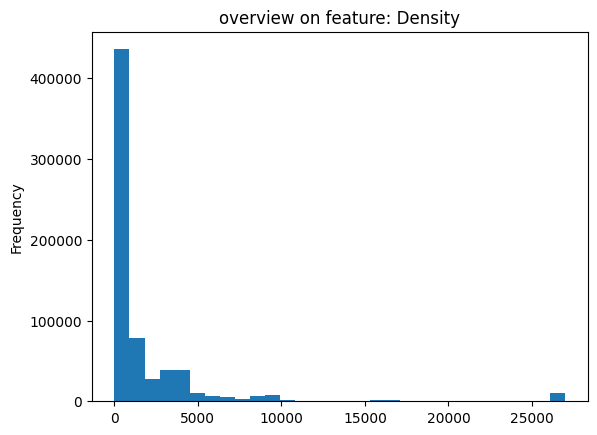

In [15]:
check_cols = ['ClaimNb', 'Exposure', 'BonusMalus', 'VehAge', 'VehPower', 'DrivAge','Density']
# do some simple hist plots for float and integer variables
for col in check_cols:
    claims_data[col].plot(kind='hist', bins = 30)
    plt.title('overview on feature: ' + col)
    plt.show()

Findings:
- ClaimNb: there are a few observations that have even more then 10 claims in the period, that seems unrealistic -> delete when nr is low or impute
- BonusMalus: hast quite a lot of categories, but most of the portfolio is on level 50, i.e.Bonus level, hardly any one is above 100 i.e. Malus 
- Brand: 3 Brands are dominating the portfolio
- Region 24 is dominating -> Paris?
- Exposure: some Exposures are >1 -> data error?

#### Further investigations of the data

In [83]:
claims_data['ClaimNb'].value_counts(dropna = False)

ClaimNb
0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
16         1
9          1
Name: count, dtype: int64

In [86]:
claims_data[claims_data['ClaimNb']>5]

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
6539,19471.0,11,1.00,A,5,6,65,50,B2,Diesel,13,R24
304484,2216294.0,6,0.33,D,4,12,52,50,B1,Regular,824,R91
320764,2239279.0,8,0.41,D,4,12,52,50,B1,Regular,824,R91
321248,2241683.0,16,0.33,D,4,12,52,50,B1,Regular,824,R91
321512,2248174.0,9,0.08,D,4,12,52,50,B1,Regular,824,R91
487268,3253234.0,11,0.08,D,4,13,53,50,B1,Regular,824,R91
488270,3254353.0,11,0.07,D,4,13,53,50,B1,Regular,824,R91


Finding / Decision:
- It is just a few records having more than five losses occured
- this seems to be really unrealistic 
- Furthermore it is still strange that their BonusMalus level is still the best: 50

- -> as it is just a few values of a large data set, leave them inside

In [92]:
claims_data[claims_data['Exposure']>1]

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
179652,1179653.0,0,1.99,A,11,10,50,50,B12,Regular,29,R25
179653,1179654.0,1,1.17,D,4,2,21,112,B6,Regular,721,R93
179655,1179656.0,1,1.12,E,6,0,37,72,B4,Diesel,9307,R82
179657,1179658.0,0,1.48,D,7,4,46,50,B6,Diesel,776,R93
179659,1179660.0,1,1.50,C,8,14,26,76,B1,Regular,372,R25
...,...,...,...,...,...,...,...,...,...,...,...,...
349346,2282494.0,0,1.06,A,5,14,62,50,B3,Regular,43,R82
352404,2285552.0,0,1.02,E,7,13,42,60,B11,Regular,3317,R93
352454,2285602.0,0,1.01,E,4,16,59,51,B1,Diesel,6736,R11
353728,2286877.0,0,1.18,C,9,16,25,68,B12,Regular,462,R72


Finding:
    - quite a high number of records has exposure > 1 which seems a bit strange as it is expected that the data set is showing 1year observations